In [1]:
import sys
!{sys.executable} -m pip install pandas numpy scikit-learn matplotlib rdkit mordred -q

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.rdmolops import SanitizeMol
from mordred import Calculator, descriptors
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import joblib

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
from rdkit import Chem

filename1 = "challenge_data_1.csv"
filename2 = "challenge_data_2.csv"
standardized_filename1 = "standardized_"+filename1
standardized_filename2 = "standardized_"+filename2
imputed_filename1= "imputed_"+filename1
imputed_filename2= "imputed_"+filename2
training_filename="imputed_AqSolDB.csv"
trained_model="random_forest_model.pkl"
image_name1 = "RF_Mordred" + filename1.split(".")[0] + "1_prediction.png"
image_name2 = "RF_Mordred" + filename2.split(".")[0] + "2_prediction.png"





df1 = pd.read_csv(filename1)
df1.head()
df2 = pd.read_csv(filename2)
df2.head()

,SMILES,LogS
0,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,-8.548020
1,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,-8.071409
2,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,-6.925969
3,CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C...,-7.535280
4,C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)...,-7.709963


In [3]:
def standardize_molecule(mol):
    """Standardize molecule using RDKit"""
    try:
        cleaner = rdMolStandardize.Cleanup(mol)
        normalizer = rdMolStandardize.Normalize(cleaner)
        reionizer = rdMolStandardize.Reionize(normalizer)
        return reionizer
    except:
        return mol

def clean_and_standardize(df):
    """Clean and standardize SMILES in dataframe"""
    valid_smiles = []
    valid_logs = []
    standardized_smiles = []
    
    for _, row in df.iterrows():
        smi = row['SMILES']
        logS = row['LogS']
        mol = Chem.MolFromSmiles(smi)
        
        if mol is not None:
            try:
                SanitizeMol(mol)
                mol = standardize_molecule(mol)
                clean_smi = Chem.MolToSmiles(mol, canonical=True)
                
                valid_smiles.append(smi)
                valid_logs.append(logS)
                standardized_smiles.append(clean_smi)
            except:
                continue
    
    clean_df = pd.DataFrame({
        'SMILES': valid_smiles,
        'LogS': valid_logs,
        'StandardizedSMILES': standardized_smiles
    })
    
    return clean_df

df1_clean = clean_and_standardize(df1)
df2_clean = clean_and_standardize(df2)

print(f"\n Challenge 1 cleaned: {df1_clean.shape[0]} molecules")
print(f" Challenge 2 cleaned: {df2_clean.shape[0]} molecules")

[18:48:03] Initializing MetalDisconnector
[18:48:03] Running MetalDisconnector
[18:48:03] Initializing Normalizer
[18:48:03] Running Normalizer
[18:48:03] Initializing Normalizer
[18:48:03] Running Normalizer
[18:48:03] Initializing MetalDisconnector
[18:48:03] Running MetalDisconnector
[18:48:03] Initializing Normalizer
[18:48:03] Running Normalizer
[18:48:03] Initializing Normalizer
[18:48:03] Running Normalizer
[18:48:03] Initializing MetalDisconnector
[18:48:03] Running MetalDisconnector
[18:48:03] Initializing Normalizer
[18:48:03] Running Normalizer
[18:48:03] Initializing Normalizer
[18:48:03] Running Normalizer
[18:48:03] Initializing MetalDisconnector
[18:48:03] Running MetalDisconnector
[18:48:03] Initializing Normalizer
[18:48:03] Running Normalizer
[18:48:03] Initializing Normalizer
[18:48:03] Running Normalizer
[18:48:03] Initializing MetalDisconnector
[18:48:03] Running MetalDisconnector
[18:48:03] Initializing Normalizer
[18:48:03] Running Normalizer
[18:48:03] Initializ


 Challenge 1 cleaned: 1763 molecules
 Challenge 2 cleaned: 2173 molecules


[18:48:06] Running Normalizer
[18:48:06] Initializing Normalizer
[18:48:06] Running Normalizer
[18:48:06] Initializing MetalDisconnector
[18:48:06] Running MetalDisconnector
[18:48:06] Initializing Normalizer
[18:48:06] Running Normalizer
[18:48:06] Initializing Normalizer
[18:48:06] Running Normalizer
[18:48:06] Initializing MetalDisconnector
[18:48:06] Running MetalDisconnector
[18:48:06] Initializing Normalizer
[18:48:06] Running Normalizer
[18:48:06] Initializing Normalizer
[18:48:06] Running Normalizer
[18:48:06] Initializing MetalDisconnector
[18:48:06] Running MetalDisconnector
[18:48:06] Initializing Normalizer
[18:48:06] Running Normalizer
[18:48:06] Initializing Normalizer
[18:48:06] Running Normalizer
[18:48:06] Initializing MetalDisconnector
[18:48:06] Running MetalDisconnector
[18:48:06] Initializing Normalizer
[18:48:06] Running Normalizer
[18:48:06] Initializing Normalizer
[18:48:06] Running Normalizer
[18:48:06] Initializing MetalDisconnector
[18:48:06] Running MetalDis

In [4]:


def calculate_mordred_descriptors(df, smiles_col='StandardizedSMILES'):
    """Calculate Mordred descriptors from SMILES after filtering invalid molecules."""
    calc = Calculator(descriptors, ignore_3D=True)
    
    mols = []
    valid_indices = []
    for idx, smi in enumerate(df[smiles_col]):
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            mols.append(mol)
            valid_indices.append(idx)
        else:
            print(f"Warning: Invalid molecule at index {idx} (SMILES: {smi}) skipped.")
    
    # Work only with valid rows
    df_valid = df.iloc[valid_indices].reset_index(drop=True)
    
    print(f"Calculating Mordred descriptors for {len(mols)} valid molecules...")
    
    desc_df = calc.pandas(mols)
    
    # Convert all to numeric
    desc_df = desc_df.apply(pd.to_numeric, errors='coerce')
    
    # Combine with valid df rows
    result_df = pd.concat([df_valid.reset_index(drop=True), desc_df.reset_index(drop=True)], axis=1)
    
    return result_df

df1_descriptors = calculate_mordred_descriptors(df1_clean)
df2_descriptors = calculate_mordred_descriptors(df2_clean)

print(f"\n Descriptors calculated!")
print(f"   Challenge 1: {df1_descriptors.shape}")
print(f"   Challenge 2: {df2_descriptors.shape}")

Calculating Mordred descriptors for 1763 valid molecules...


 15%|████████████████████████████████▏                                                                                                                                                                                  | 269/1763 [00:04<00:16, 91.06it/s]

/opt/miniconda3/envs/cadd2025/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1763/1763 [00:21<00:00, 83.42it/s]


Calculating Mordred descriptors for 2170 valid molecules...


[18:48:29] Can't kekulize mol.  Unkekulized atoms: 8 19
[18:48:29] Can't kekulize mol.  Unkekulized atoms: 9 19
[18:48:29] Can't kekulize mol.  Unkekulized atoms: 10 22
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 1187/2170 [00:11<00:08, 115.98it/s]

/opt/miniconda3/envs/cadd2025/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2170/2170 [00:19<00:00, 110.26it/s]



 Descriptors calculated!
   Challenge 1: (1763, 1616)
   Challenge 2: (2170, 1616)


In [5]:
def calculate_mordred_descriptors(df):
    calc = Calculator(descriptors, ignore_3D=True)
    
    mols = []
    valid_indices = []
    
    for idx, smi in enumerate(df['StandardizedSMILES']):
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            mols.append(mol)
            valid_indices.append(idx)
        else:
            print(f"Warning: Invalid SMILES at index {idx}: {smi} - skipping.")
    
    df_valid = df.iloc[valid_indices].reset_index(drop=True)
    
    print(f"Calculating Mordred descriptors for {len(mols)} valid molecules...")
    
    desc_df = calc.pandas(mols)
    desc_df = desc_df.apply(pd.to_numeric, errors='coerce')
    
    result_df = pd.concat([df_valid, desc_df.reset_index(drop=True)], axis=1)
    
    return result_df

df1_descriptors = calculate_mordred_descriptors(df1_clean)
df2_descriptors = calculate_mordred_descriptors(df2_clean)

print(f"\n Descriptors calculated!")
print(f"   Challenge 1: {df1_descriptors.shape}")
print(f"   Challenge 2: {df2_descriptors.shape}")


Calculating Mordred descriptors for 1763 valid molecules...


 16%|█████████████████████████████████▏                                                                                                                                                                                 | 277/1763 [00:04<00:16, 88.80it/s]

/opt/miniconda3/envs/cadd2025/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1763/1763 [00:25<00:00, 69.28it/s]


Calculating Mordred descriptors for 2170 valid molecules...


[18:49:16] Can't kekulize mol.  Unkekulized atoms: 8 19
[18:49:16] Can't kekulize mol.  Unkekulized atoms: 9 19
[18:49:16] Can't kekulize mol.  Unkekulized atoms: 10 22
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 1190/2170 [00:10<00:07, 122.95it/s]

/opt/miniconda3/envs/cadd2025/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2170/2170 [00:19<00:00, 112.00it/s]



 Descriptors calculated!
   Challenge 1: (1763, 1616)
   Challenge 2: (2170, 1616)


In [6]:
df_train = pd.read_csv(training_filename)

# Get feature column names (all columns after first 5)
feature_cols = df_train.columns[5:].tolist()

print(f"\nTraining model used {len(feature_cols)} features")

# Extract only the features that were used in training
X1 = df1_descriptors[feature_cols]
X2 = df2_descriptors[feature_cols]

# Get actual LogS values
y1_true = df1_descriptors['LogS'].values
y2_true = df2_descriptors['LogS'].values

print(f"\n Features aligned!")
print(f"   Challenge 1 features: {X1.shape}")
print(f"   Challenge 2 features: {X2.shape}")


Training model used 1534 features

 Features aligned!
   Challenge 1 features: (1763, 1534)
   Challenge 2 features: (2170, 1534)


In [7]:
try:
    model_rf = joblib.load(trained_model)
    print("\n Model loaded successfully!")
except FileNotFoundError:
    print("\n Error: Could not find 'random_forest_model.pkl'")
    print("Please make sure you saved your model in the RF training notebook using:")
    print("joblib.dump(model_rf, 'random_forest_model.pkl')")
    raise



 Model loaded successfully!


In [8]:
y1_pred = model_rf.predict(X1)
y2_pred = model_rf.predict(X2)

print("\n Predictions completed!")
print(f"   Challenge 1: {len(y1_pred)} predictions")
print(f"   Challenge 2: {len(y2_pred)} predictions")


 Predictions completed!
   Challenge 1: 1763 predictions
   Challenge 2: 2170 predictions


In [9]:
def evaluate_predictions(y_true, y_pred, dataset_name):
    """Calculate and print evaluation metrics"""
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"\n{'='*50}")
    print(f" {dataset_name} EVALUATION")
    print(f"{'='*50}")
    print(f"R² Score:  {r2:.4f}")
    print(f"RMSE:      {rmse:.4f}")
    print(f"MAE:       {mae:.4f}")
    print(f"{'='*50}")
    
    return r2, rmse, mae

r2_1, rmse_1, mae_1 = evaluate_predictions(y1_true, y1_pred, "Challenge Data 1")
r2_2, rmse_2, mae_2 = evaluate_predictions(y2_true, y2_pred, "Challenge Data 2")



 Challenge Data 1 EVALUATION
R² Score:  -0.5447
RMSE:      1.2004
MAE:       0.9410

 Challenge Data 2 EVALUATION
R² Score:  -24.8306
RMSE:      3.5884
MAE:       3.4472



 Plot saved as 'challenge_predictions.png'


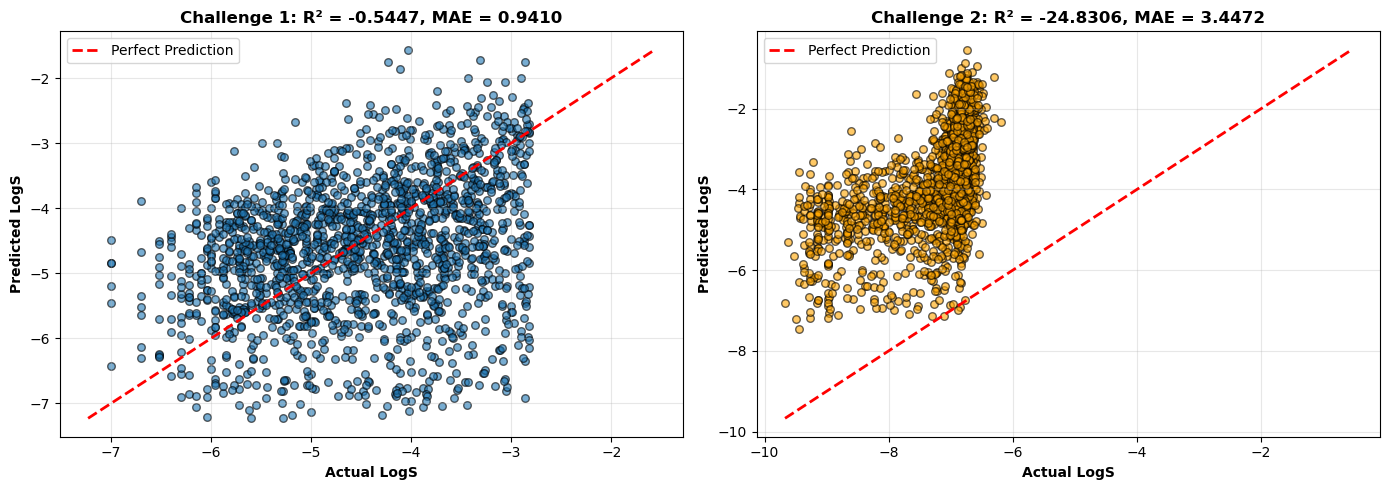

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Challenge 1 plot
axes[0].scatter(y1_true, y1_pred, alpha=0.6, edgecolors='k', s=30)
min_val = min(y1_true.min(), y1_pred.min())
max_val = max(y1_true.max(), y1_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual LogS', fontweight='bold')
axes[0].set_ylabel('Predicted LogS', fontweight='bold')
axes[0].set_title(f'Challenge 1: R² = {r2_1:.4f}, MAE = {mae_1:.4f}', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Challenge 2 plot
axes[1].scatter(y2_true, y2_pred, alpha=0.6, edgecolors='k', s=30, color='orange')
min_val = min(y2_true.min(), y2_pred.min())
max_val = max(y2_true.max(), y2_pred.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual LogS', fontweight='bold')
axes[1].set_ylabel('Predicted LogS', fontweight='bold')
axes[1].set_title(f'Challenge 2: R² = {r2_2:.4f}, MAE = {mae_2:.4f}', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('challenge_predictions.png', dpi=300, bbox_inches='tight')
print("\n Plot saved as 'challenge_predictions.png'")
plt.show()